In [1]:
import numpy as np
import pandas as pd

In [2]:
train=pd.read_csv('train.csv')

In [5]:
test=pd.read_csv('/content/drive/MyDrive/datasets/test.csv')

In [3]:
meal=pd.read_csv('meal_info.csv')

In [5]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [6]:
train=train.merge(meal, on='meal_id')

In [7]:
center_id = 55
meal_id = 1993

In [8]:
train_df = train[train['center_id']==center_id]
train_df = train_df[train_df['meal_id']==meal_id]

In [11]:
#preprocessing task for time series analysis
def pretime(train_df):
  period = len(train_df)
  train_df['Date'] = pd.date_range('2015-01-08', periods=period, freq='W')
  train_df['Day'] = train_df['Date'].dt.day
  train_df['Month'] = train_df['Date'].dt.month
  train_df['Year'] = train_df['Date'].dt.year
  train_df['Quarter'] = train_df['Date'].dt.quarter


In [12]:
pretime(train_df)

In [13]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,Date,Day,Month,Year,Quarter
11092,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,2015-01-11,11,1,2015,1
11169,1035555,2,55,1993,133.89,133.89,0,0,121,Beverages,Thai,2015-01-18,18,1,2015,1
11246,1282652,3,55,1993,134.86,133.86,0,0,258,Beverages,Thai,2015-01-25,25,1,2015,1
11323,1066744,4,55,1993,134.89,133.89,0,0,82,Beverages,Thai,2015-02-01,1,2,2015,1
11400,1115779,5,55,1993,147.50,145.50,0,0,81,Beverages,Thai,2015-02-08,8,2,2015,1


**xb regressor**

In [14]:
xb_data = train_df.drop(columns=['id','center_id','meal_id','category','cuisine'])
xb_data = xb_data.set_index(['Date'])

In [15]:
period=len(train_df)


In [16]:
x_train = xb_data.drop(columns='num_orders')
y_train = xb_data['num_orders']
y_train = np.log1p(y_train)
split_size = period-15
X_train = x_train.iloc[:split_size,:]
X_test = x_train.iloc[split_size:,:]
Y_train = y_train.iloc[:split_size]
Y_test = y_train.iloc[split_size:]

In [17]:
from xgboost import XGBRegressor
model_2 = XGBRegressor(
learning_rate = 0.01,
eval_metric ='rmse',
n_estimators = 50000,
max_depth = 5,
subsample = 0.8,
colsample_bytree = 1,
gamma = 0.5
)
#model.fit(X_train, y_train)
model_2.fit(X_train, Y_train,
eval_set=[(X_test, Y_test)], early_stopping_rounds=500, verbose=100)

[0]	validation_0-rmse:0.59273
[100]	validation_0-rmse:0.53061
[200]	validation_0-rmse:0.49682


c:\Users\Pranav\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[300]	validation_0-rmse:0.48364
[400]	validation_0-rmse:0.47352
[500]	validation_0-rmse:0.47175
[600]	validation_0-rmse:0.46748
[700]	validation_0-rmse:0.46513
[800]	validation_0-rmse:0.46556
[900]	validation_0-rmse:0.46103
[1000]	validation_0-rmse:0.45753
[1100]	validation_0-rmse:0.45510
[1200]	validation_0-rmse:0.45271
[1300]	validation_0-rmse:0.45215
[1400]	validation_0-rmse:0.45188
[1500]	validation_0-rmse:0.44951
[1600]	validation_0-rmse:0.45097
[1700]	validation_0-rmse:0.45040
[1800]	validation_0-rmse:0.45151
[1900]	validation_0-rmse:0.45132
[1980]	validation_0-rmse:0.44960


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0.5,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
a = (model_2.get_booster().best_iteration)

In [20]:
xgb_model = XGBRegressor(
learning_rate = 0.01,
n_estimators = a,
max_depth = 5,
subsample = 0.8,
colsample_bytree = 1,
gamma = 0.5)

xgb_model.fit(X_train, Y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_preds = np.exp(xgb_preds)
xgb_preds = pd.DataFrame(xgb_preds)
xgb_preds.index = Y_test.index
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)

In [21]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(Y_test, xgb_preds, squared=False))


58.5972486214458


**FB PROPHET**

In [24]:
#preprocessing for fb prophet
prophet_data=train_df
def preprophet():
  global prophet_data
  prophet_data = train_df[['Date','num_orders']]
  prophet_data.index = xb_data.index
  prophet_data = prophet_data.iloc[:split_size,:]
  prophet_data =prophet_data.rename(columns={'Date':'ds',
  'num_orders':'y'})
  print(prophet_data.head())
preprophet()


                   ds    y
Date                      
2015-01-11 2015-01-11  270
2015-01-18 2015-01-18  121
2015-01-25 2015-01-25  258
2015-02-01 2015-02-01   82
2015-02-08 2015-02-08   81


In [25]:
from prophet import Prophet
m = Prophet(growth='linear',
  seasonality_mode='multiplicative',
  # changepoint_prior_scale = 30,
  seasonality_prior_scale = 35,
  holidays_prior_scale = 10,
  daily_seasonality = True,
  weekly_seasonality = False,
  yearly_seasonality= False,
  ).add_seasonality(
  name='monthly',
  period=30.5,
  fourier_order=30
  ).add_seasonality(
  name='weekly',
  period=7,
  fourier_order=55
  ).add_seasonality(
  name='yearly',
  period=365.25,
  fourier_order=20
  )
m.fit(prophet_data)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1_zw1wzx/21ukmq6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1_zw1wzx/pqyowkff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73024', 'data', 'file=/tmp/tmp1_zw1wzx/21ukmq6v.json', 'init=/tmp/tmp1_zw1wzx/pqyowkff.json', 'output', 'file=/tmp/tmp1_zw1wzx/prophet_modelsusk47zl/prophet_model-20240126162232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [26]:
future = m.make_future_dataframe(periods=15, freq='W')

In [27]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
140,2017-09-17,198.027461,143.887760,246.622382
141,2017-09-24,131.304826,76.710325,185.023659
142,2017-10-01,232.997975,179.996796,286.614158
143,2017-10-08,219.914622,162.817981,275.506856
144,2017-10-15,46.337166,-3.807948,99.504034


In [28]:
prophet_preds = forecast['yhat'].iloc[split_size:]
prophet_preds.index = Y_test.index


In [29]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(Y_test, prophet_preds, squared=False))


75.69553043100028


**arima**

In [31]:
import seaborn as sns
data = train[train['center_id']==55]
data = data[data['meal_id']==1885]
period = len(data)
data['Date'] = pd.date_range('2015-01-08', periods=period, freq='W')

In [32]:
df_ari = data[['Date','num_orders']]
df_ari = df_ari.set_index(['Date'])
df_ari.head()

,num_orders
Date,
2015-01-11,177
2015-01-18,323
2015-01-25,96
2015-02-01,163
2015-02-08,215


In [33]:
df_ari


,num_orders
Date,
2015-01-11,177
2015-01-18,323
2015-01-25,96
2015-02-01,163
2015-02-08,215
...,...
2017-09-17,107
2017-09-24,121
2017-10-01,176


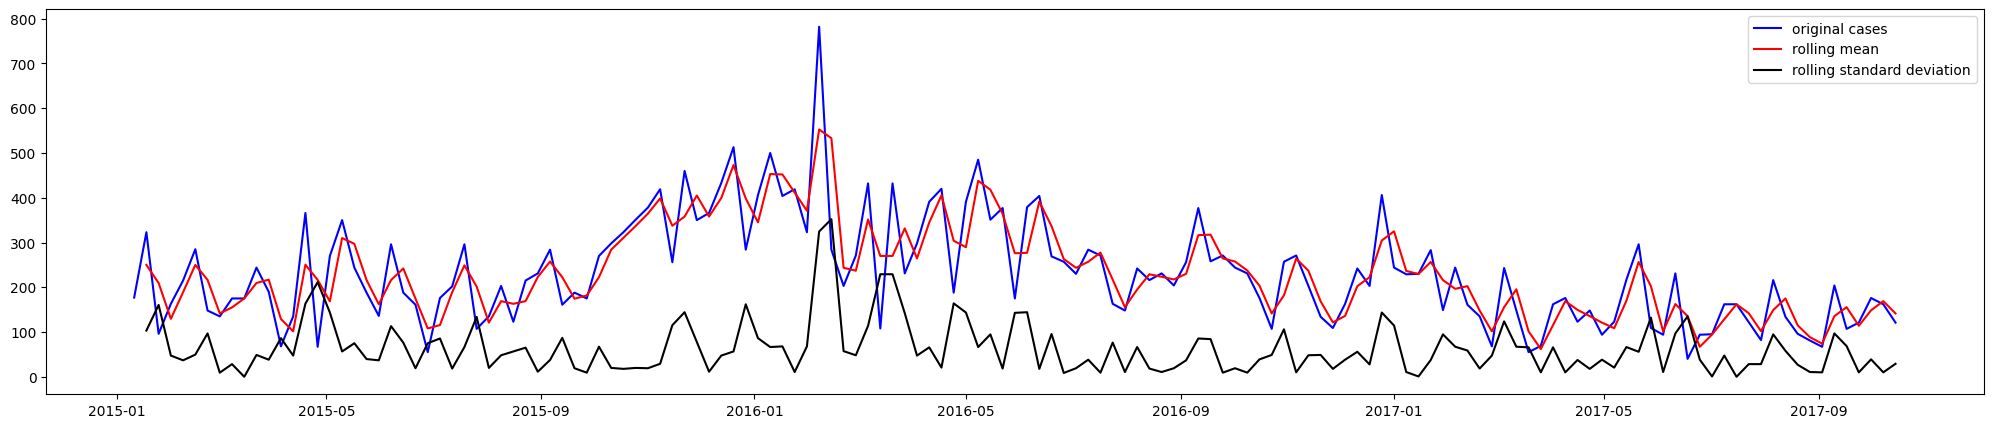

test statitics             -1.207952
p_value                     0.670166
lags used                  12.000000
number of observations    132.000000
critcal value (1%)         -3.480888
critcal value (5%)         -2.883697
critcal value (10%)        -2.578586
dtype: float64


In [36]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
def test(data):
  rolmean = data.rolling(window=2).mean()
  rolstd = data.rolling(window=2).std()
  plt.figure(figsize=(25,5))
  plt.plot(data, color='blue', label='original cases')
  plt.plot(rolmean, color='red', label='rolling mean')
  plt.plot(rolstd, color='black', label='rolling standard deviation')
  plt.legend(loc='best')
  plt.show()
  dftest = adfuller(data['num_orders'], autolag = 't-stat')
  dfoutput = pd.Series(dftest[0:4], index=['test statitics','p_value','lags used','number of observations'])
  for key,value in dftest[4].items():
    dfoutput['critcal value (%s)'%key] = value
  print(dfoutput)
test(df_ari)


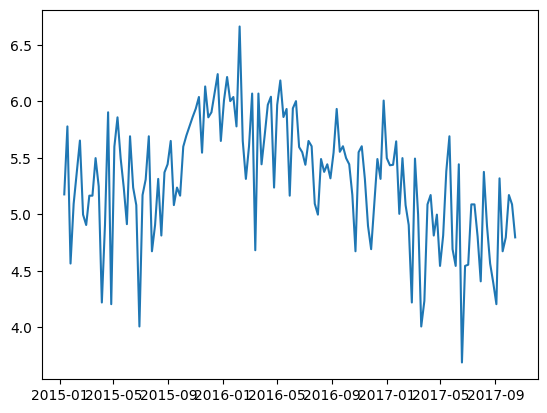

In [37]:
import numpy as np
df_log = np.log(df_ari)
plt.plot(df_log)

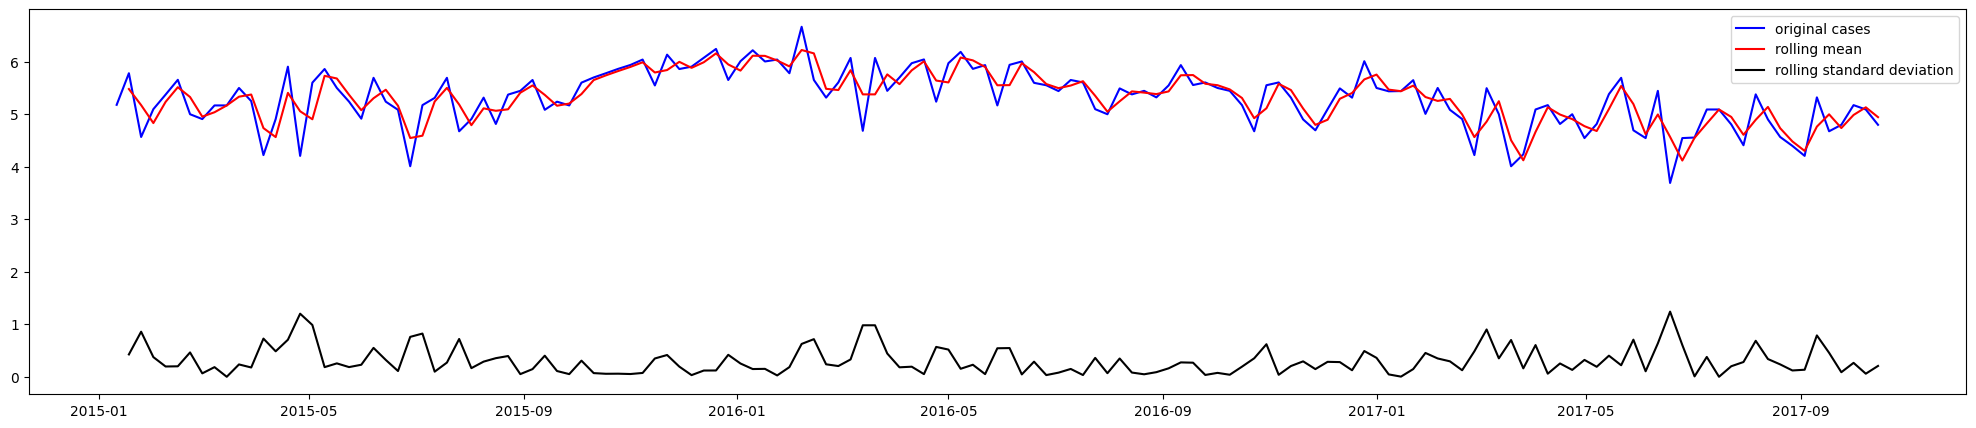

test statitics             -0.943697
p_value                     0.773242
lags used                  12.000000
number of observations    132.000000
critcal value (1%)         -3.480888
critcal value (5%)         -2.883697
critcal value (10%)        -2.578586
dtype: float64


In [38]:
test(df_log)


In [39]:
movingaverage = df_log.rolling(window=4).mean()
df_log_minus = df_log - movingaverage #applying differencing after log transformation
df_log_minus.dropna(inplace=True)
df_log_minus.head(12)

,num_orders
Date,
2015-02-01,-0.059225
2015-02-08,0.169041
2015-02-15,0.482183
2015-02-22,-0.281310
2015-03-01,-0.326129
2015-03-08,-0.015155
2015-03-15,0.106771
2015-03-22,0.314164
2015-03-29,-0.021417


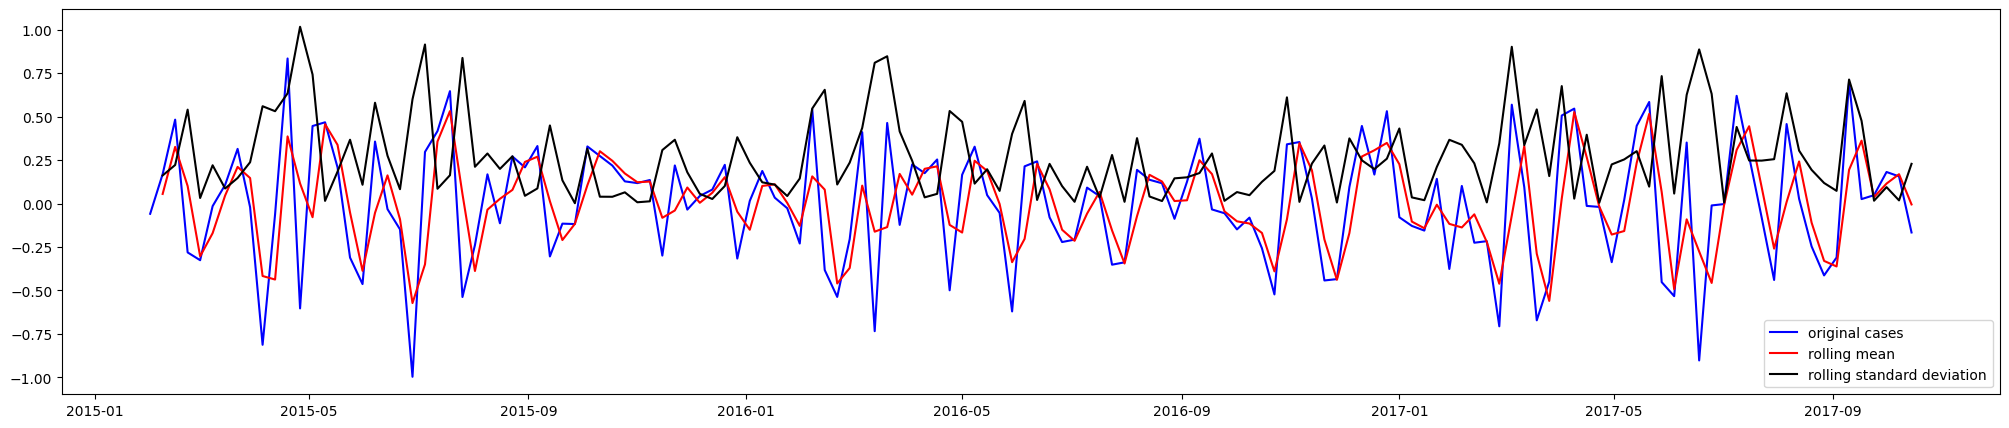

test statitics             -4.487860
p_value                     0.000207
lags used                  14.000000
number of observations    127.000000
critcal value (1%)         -3.482920
critcal value (5%)         -2.884580
critcal value (10%)        -2.579058
dtype: float64


In [40]:
test(df_log_minus)

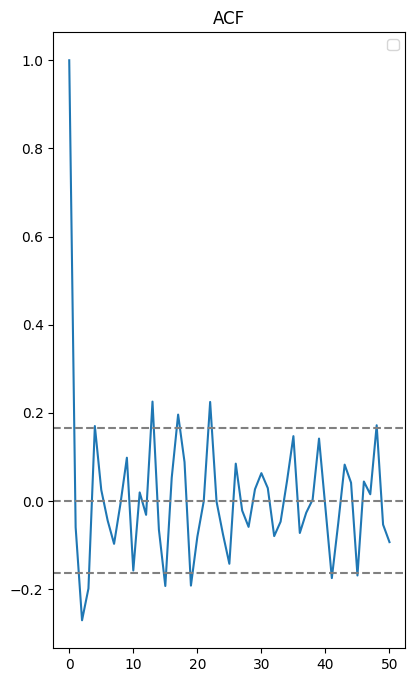

In [41]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(df_log_minus, nlags=50)
lag_pacf = pacf(df_log_minus, nlags=20, method='ols')
plt.figure(figsize=(10,8))
#plot acf gives p values
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_minus)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_minus)), linestyle='--', color='gray')
plt.title('ACF')
plt.legend(loc='best')

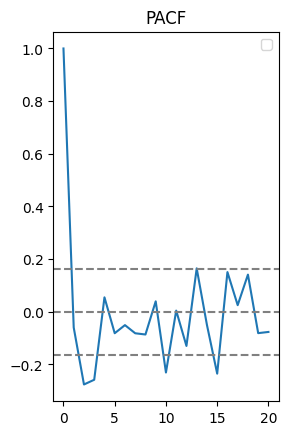

In [42]:
#plot pacf gives q value
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_minus)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_minus)), linestyle='--', color='gray')
plt.title('PACF')
plt.legend(loc='best')


In [43]:
df_log.head()

,num_orders
Date,
2015-01-11,5.176150
2015-01-18,5.777652
2015-01-25,4.564348
2015-02-01,5.093750
2015-02-08,5.370638


In [44]:
ts_values=df_log.values
print(train)
X = ts_values
size = int(len(X) * 0.667)
train, test = X[0:size], X[size:len(X)]


             id  week  center_id  meal_id  checkout_price  base_price  \
0       1379560     1         55     1885          136.83      152.29   
1       1040403     1         24     1885          136.83      136.83   
2       1103215     1         11     1885          136.83      136.83   
3       1034383     1         83     1885          121.31      120.31   
4       1118999     1         32     1885          114.52      113.52   
...         ...   ...        ...      ...             ...         ...   
456543  1458599   145         65     2104          582.03      582.03   
456544  1417199   145        110     2104          582.03      581.03   
456545  1434028   145         68     2104          582.03      581.03   
456546  1205895   145         51     2104          641.23      640.23   
456547  1443704   145         61     2104          581.03      582.03   

        emailer_for_promotion  homepage_featured  num_orders   category  \
0                           0                  0

In [45]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from numpy.linalg import LinAlgError
import warnings
warnings.filterwarnings("ignore")

In [46]:
history = [x for x in train]
predictions = list()
#test.reset_index()
for t in range(len(test)):
    try:
        model = ARIMA(history, order=(1,0,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    except (ValueError, LinAlgError):
        pass
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rmse = mean_squared_error(test, predictions)**0.5
print('Test MSE: %.3f' % rmse)


from math import sqrt
rms = sqrt(mean_squared_error(test, predictions))

predicted=5.405677, expected=5.313206
predicted=5.391532, expected=4.897840
predicted=5.308187, expected=4.691348
predicted=5.199541, expected=5.093750
predicted=5.188005, expected=5.488938
predicted=5.254840, expected=5.313206
predicted=5.272617, expected=6.006353
predicted=5.410353, expected=5.497168
predicted=5.427621, expected=5.433722
predicted=5.429299, expected=5.438079
predicted=5.431365, expected=5.645447
predicted=5.470154, expected=5.003946
predicted=5.386762, expected=5.497168
predicted=5.408050, expected=5.081404
predicted=5.353326, expected=4.905275
predicted=5.278863, expected=4.219508
predicted=5.082872, expected=5.493061
predicted=5.182341, expected=4.997212
predicted=5.157955, expected=4.007333
predicted=4.938984, expected=4.234107
predicted=4.781985, expected=5.087596
predicted=4.881493, expected=5.170484
predicted=4.965432, expected=4.812184
predicted=4.949238, expected=4.997212
predicted=4.976446, expected=4.543295
predicted=4.898695, expected=4.812184
predicted=4.

In [47]:
from math import sqrt
rms = sqrt(mean_squared_error(np.exp(test), np.exp(predictions)))
print('root Mean Squarred Error: %.2f'% rms)

root Mean Squarred Error: 69.02


In [48]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


x_train = xb_data.drop(columns='num_orders')
y_train = xb_data['num_orders']
y_train = np.log1p(y_train)
split_size = period - 15
X_train = x_train.iloc[:split_size, :]
X_test = x_train.iloc[split_size:, :]
Y_train = y_train.iloc[:split_size]
Y_test = y_train.iloc[split_size:]


models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Lasso': Lasso(),
    'Extra Trees': ExtraTreesRegressor()
}


mse_results = {}


for model_name, model in models.items():
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)


    inverse_predictions = np.expm1(predictions)

    inverse_predictions = pd.DataFrame(inverse_predictions)
    inverse_predictions.index = Y_test.index

    mse = mean_squared_error(np.exp(Y_test), inverse_predictions)
    mse_results[model_name] = mse

    print(model_name,"--->",mse)



mse_df = pd.DataFrame(list(mse_results.items()), columns=['Model', 'MSE'])
mse_df.sort_values(by='MSE', inplace=True)


Linear Regression ---> 7849.497865975764
Decision Tree ---> 26353.866666666665
Random Forest ---> 5819.082386831511
AdaBoost ---> 5292.300681905853
Gradient Boosting ---> 1930.5017329560337
Lasso ---> 7795.2728859309145
Extra Trees ---> 4913.905381189941
